In [ ]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

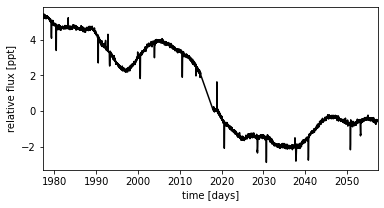

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u

url = "https://archive.stsci.edu/hlsps/everest/v2/c01/201300000/67065/hlsp_everest_k2_llc_201367065-c01_kepler_v2.0_lc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    t = data["TIME"]
    y = data["FLUX"]
    q = data["QUALITY"]
    
# This is from the EVEREST source. These are the flagged data points
m = np.isfinite(t) & np.isfinite(y)
for b in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]:
    m &= (q & (2 ** (b - 1))) == 0

t = np.ascontiguousarray(t[m], dtype=np.float64) * u.day
y = np.ascontiguousarray(y[m], dtype=np.float64)
y = (y / np.median(y) - 1)*1e3

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(t, y, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]");

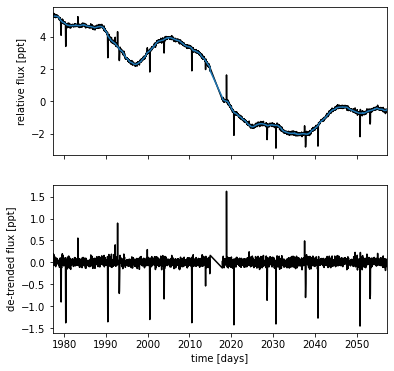

In [ ]:
from scipy.signal import medfilt
trend = medfilt(y, 45)
mu = np.median(y)
y_filt =(y - trend)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("relative flux [ppt]")

ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min().value, t.max().value)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

In [ ]:
from astropy.stats import BoxLeastSquares

durations = np.linspace(0.05, 0.2, 10) * u.day
model = BoxLeastSquares(t, y_filt)
results = model.autopower(durations, frequency_factor=5.0)
print(results)

          depth: array([0.01149651, 0.01286837, 0.01267318, ..., 0.69284145, 0.72999508,
       0.61095512])
      depth_err: array([0.04057764, 0.04061618, 0.04059689, ..., 0.3337471 , 0.37832923,
       0.316664  ])
      depth_snr: array([0.28332141, 0.3168287 , 0.31217112, ..., 2.07594748, 1.92952335,
       1.92934819])
       duration: <Quantity [0.085, 0.085, 0.085, ..., 0.085, 0.065, 0.085] d>
 log_likelihood: array([0.05095148, 0.06367127, 0.06183461, ..., 2.16013173, 1.86512486,
       1.8663308 ])
      objective: 'likelihood'
         period: <Quantity [ 0.4       ,  0.40000624,  0.40001248, ..., 39.90183014,
           39.96400821, 40.02638037] d>
          power: array([0.05095148, 0.06367127, 0.06183461, ..., 2.16013173, 1.86512486,
       1.8663308 ])
   transit_time: <Quantity [1977.60494947, 1977.60494947, 1977.60494947, ..., 1990.78994947,
           2010.57494947, 1990.66494947] d>


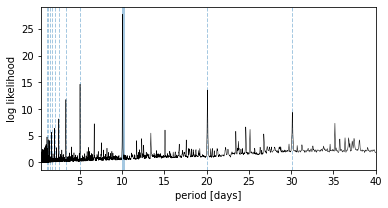

In [ ]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period.value, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period.value / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

ax.set_xlim(results.period.min().value, results.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

In [ ]:
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

model.compute_stats(period, duration, t0)

{'depth': (1.1936640429140075, 0.16099485890719112),
 'depth_even': (1.1560693853875603, 0.22422827420626673),
 'depth_half': (0.6516435512927655, 0.11985544224872362),
 'depth_odd': (1.2332373666260577, 0.2300215161694426),
 'depth_phased': (-0.008847884051252572, 0.17756919776352992),
 'harmonic_amplitude': 0.024328101050625044,
 'harmonic_delta_log_likelihood': -26.950854196140387,
 'per_transit_count': array([5, 4, 5, 5, 5, 5, 5, 5]),
 'per_transit_log_likelihood': array([3.52474809, 3.16992881, 2.92304483, 3.24175477, 3.60949244,
        4.08972639, 3.2935453 , 3.9320194 ]),
 'transit_times': <Quantity [1980.41744947, 1990.47192245, 2000.52639544, 2010.58086842,
            2020.63534141, 2030.68981439, 2040.74428738, 2050.79876036] d>}

In [ ]:
model.compute_stats?

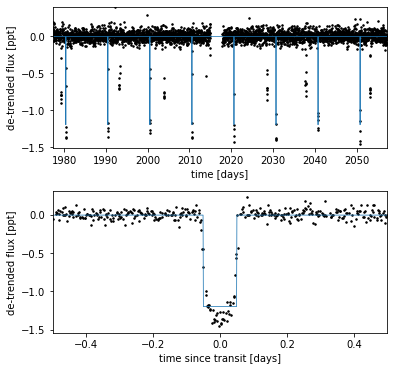

In [ ]:
# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(t, y_filt, ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model.model(x, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(t.min().value, t.max().value)
ax.set_ylim(-1.52, 0.4)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = (t - t0 + 0.5*period) % period - 0.5*period
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[m], ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model.model(x + t0, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

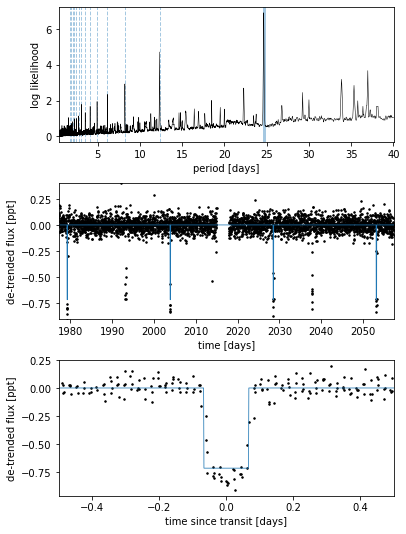

In [ ]:
# Find the in-transit points using a longer duration as a buffer to avoid ingress and egress
in_transit = model.transit_mask(t, period, 2*duration, t0)

# Re-run the algorithm, and plot the results
model2 = BoxLeastSquares(t[~in_transit], y_filt[~in_transit])
results2 = model2.autopower(durations, frequency_factor=5.0)

# Extract the parameters of the best-fit model
index = np.argmax(results2.power)
period2 = results2.period[index]
t02 = results2.transit_time[index]
duration2 = results2.duration[index]

fig, axes = plt.subplots(3, 1, figsize=(6, 9))
fig.subplots_adjust(hspace=0.3)

# Highlight the harmonics of the peak period
ax = axes[0]
ax.axvline(period2.value, alpha=0.4, lw=3)
for n in range(2, 15):
    ax.axvline(n*period2.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period2.value / n, alpha=0.4, lw=1, linestyle="dashed")
# Plot the periodogram
ax.plot(results2.period, results2.power, "k", lw=0.5)

ax.set_xlim(results2.period.min().value, results2.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Plot the light curve and best-fit model
ax = axes[1]
ax.plot(t[~in_transit], y_filt[~in_transit], ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model2.model(x, period2, duration2, t02)
ax.plot(x, f, lw=0.75)
ax.set_xlim(t.min().value, t.max().value)
ax.set_ylim(-0.9, 0.4)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

ax = axes[2]
x = (t[~in_transit] - t02 + 0.5*period2) % period2 - 0.5*period2
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[~in_transit][m], ".k", ms=3)
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model2.model(x + t02, period2, duration2, t02)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

In [ ]:
model2.compute_stats(period2, duration2, t02)

{'depth': (0.715043514396489, 0.19318468664989263),
 'depth_even': (0.7123371517788664, 0.2677906972759726),
 'depth_half': (0.48083811435047075, 0.15901048153677036),
 'depth_odd': (0.717958058753929, 0.2778603300977977),
 'depth_phased': (-0.0055460654147383315, 0.2778622143466659),
 'harmonic_amplitude': 0.006326957227948598,
 'harmonic_delta_log_likelihood': -6.814594921506446,
 'per_transit_count': array([7, 6, 7, 7]),
 'per_transit_log_likelihood': array([1.93436162, 1.73324562, 1.61755663, 1.6172137 ]),
 'transit_times': <Quantity [1979.27994947, 2003.92243713, 2028.56492479, 2053.20741246] d>}

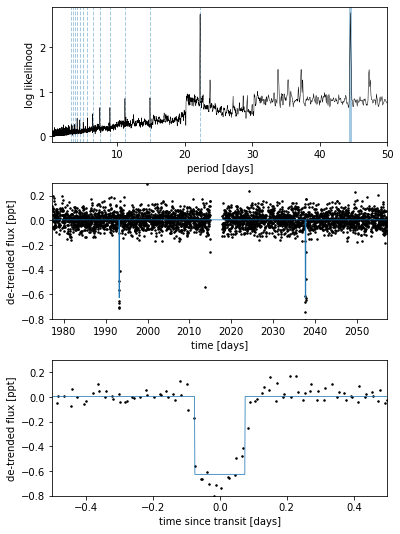

In [ ]:
in_transit2 = in_transit | model2.transit_mask(t, period2, 2*duration2, t02)

# Re-run the algorithm, and plot the results
 results3 = model3.autopower(durations, maximum_period=50, frequency_factor=5.0)

# Extract the parameters of the best-fit model
index = np.argmax(results3.power)
period3 = results3.period[index]
t03 = results3.transit_time[index]
duration3 = results3.duration[index]

fig, axes = plt.subplots(3, 1, figsize=(6, 9))
fig.subplots_adjust(hspace=0.3)

# Highlight the harmonics of the peak period
ax = axes[0]
ax.axvline(period3.value, alpha=0.4, lw=3)
for n in range(2, 15):
    ax.axvline(n*period3.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period3.value / n, alpha=0.4, lw=1, linestyle="dashed")
# Plot the periodogram
ax.plot(results3.period, results3.power, "k", lw=0.5)

ax.set_xlim(results3.period.min().value, results3.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

ax = axes[1]
ax.plot(t[~in_transit2], y_filt[~in_transit2], ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model3.model(x, period3, duration3, t03)
ax.plot(x, f, lw=0.75)
ax.set_xlim(t.min().value, t.max().value)
ax.set_ylim(-0.8, 0.3)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]")
ax = axes[2]
x = (t[~in_transit2] - t03 + 0.5*period3) % period3 - 0.5*period3
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[~in_transit2][m], ".k", ms=3)
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model3.model(x + t03, period3, duration3, t03)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.8, 0.3)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

In [ ]:
model3.compute_stats(period3, duration3, t03)

{'depth': (0.6300701086907579, 0.26779614700606896),
 'depth_even': (0.6037961230459885, 0.3783428970918676),
 'depth_half': (0.6300701086907579, 0.26779614700606896),
 'depth_odd': (0.6563440943355274, 0.3783428970918676),
 'depth_phased': (0.0, inf),
 'harmonic_amplitude': 0.005333443578734813,
 'harmonic_delta_log_likelihood': -2.74679750019782,
 'per_transit_count': array([7, 7]),
 'per_transit_log_likelihood': array([1.27357803, 1.50534037]),
 'transit_times': <Quantity [1993.23244947, 2037.77777645] d>}